In [27]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict 
import sys
import re
import math
from collections import OrderedDict 

In [33]:
# read file ktotal
df_ktotal = pd.read_csv('ktotal_contratos.csv')
# clean data
### format col names 
df_ktotal.columns = df_ktotal.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### exclude cancelled contracts
#df_ktotal = df_ktotal[df_ktotal['cct_contract_status_id']!=3]
### select and rename relevant cols
df_ktotal = df_ktotal[['cct_ctl_id','cct_warranty_start_date', 'cct_hiring_date', 'cct_contract_source', 
                       'cct_plan_id', 'cct_contract_status_id']]
df_ktotal = df_ktotal.rename(columns={'cct_ctl_id': 'stockid', 'cct_warranty_start_date':'date_delivery', 
                                      'cct_hiring_date':'date_activation', 
                                      'cct_contract_source':'source', 'cct_plan_id':'payment'})
### format date delivery col
df_ktotal['date_delivery'] = pd.to_datetime(df_ktotal['date_delivery'])
### format date activation col
df_ktotal['date_activation'] = pd.to_datetime(df_ktotal['date_activation']).dt.date
### sort, filter by, and format stockid
df_ktotal = df_ktotal.sort_values('date_delivery', ascending=False)
df_ktotal = df_ktotal.drop_duplicates('stockid')
df_ktotal['stockid'] = df_ktotal['stockid'].astype(int)
# examine data
print(df_ktotal.shape)
df_ktotal.head()

(1804, 6)


,stockid,date_delivery,date_activation,source,payment,cct_contract_status_id
966,28419,2020-12-09,2020-11-24,3,0,1
1296,20045,2020-12-03,2020-11-23,3,0,1
925,22658,2020-12-01,2020-11-18,2,1,1
1119,23694,2020-12-01,2020-11-24,3,0,1
978,20787,2020-11-30,2020-11-14,2,1,1


In [13]:
len(df_ktotal[df_ktotal['cct_contract_status_id']==2])

92

In [14]:
# read file kcapital
df_kcapital = pd.read_csv("kcapital_contratos.csv")
# clean data
### clean col names
df_kcapital.columns = df_kcapital.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### format date col
df_kcapital['dia_solicitud_aprobada'] = pd.to_datetime(df_kcapital['dia_solicitud_aprobada'], dayfirst=True)
### only include cars with kcapital
df_kcapital =  df_kcapital[df_kcapital['financiamiento_ganado'] == 'Yes']
### select and rename relevant cols
df_kcapital = df_kcapital[['stock_id','dia_solicitud_aprobada']]
df_kcapital = df_kcapital.rename(columns={'dia_solicitud_aprobada': 'date_approved', 'stock_id':'stockid'})
### format stockid col
df_kcapital['stockid'] = df_kcapital['stockid'].astype(int)
### sort and filter by stockid
df_kcapital = df_kcapital.sort_values('date_approved', ascending=False)
df_kcapital = df_kcapital.drop_duplicates('stockid')
# examine data
print(df_kcapital.shape)
df_kcapital.head()

(1160, 2)


,stockid,date_approved
2265,23178,2020-11-30
2955,21405,2020-11-28
2753,26318,2020-11-28
2656,23044,2020-11-28
2945,22323,2020-11-28


In [15]:
# read file entregas
df_entregas = pd.read_csv("entregas.csv")
# clean data
### format col names
df_entregas.columns = df_entregas.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_entregas = df_entregas[['estimate_asociado','auto', 'fecha_de_entrega_agendada',
                           'hora', "tipo_de_lugar_destino", 'responsable_em_venta']]
df_entregas = df_entregas.rename(columns={'estimate_asociado': 'estimate', 'auto':'stockid', 
                                          'fecha_de_entrega_agendada':'date_delivery', 'hora':'hour', 
                                          'tipo_de_lugar_destino':'hub',
                                          "responsable_em_venta":'salesperson'})
### format, filter by, and sort by date col
df_entregas['date_delivery'] = pd.to_datetime(df_entregas['date_delivery'],  dayfirst=True)
min_date = df_ktotal['date_delivery'].min()
df_entregas = df_entregas[df_entregas['date_delivery'] >= min_date]
df_entregas = df_entregas.sort_values('date_delivery', ascending=False)
### format and filter by stockid col
def extr_stockid(auto):
    return re.findall('[\d]+', auto)[0]
df_entregas['stockid'] = df_entregas['stockid'].apply(extr_stockid)
df_entregas = df_entregas.drop_duplicates('stockid')
### format estimate col
df_entregas['estimate'] = df_entregas['estimate'].str[10:]
# examine data
print(df_entregas.shape)
df_entregas.head()

(8642, 6)


,estimate,stockid,date_delivery,hour,hub,salesperson
13042,3172862,22155,2020-12-10,15:45,SAN ANGEL,Andres Jhovanny Hernandez Cuevas
13041,3185133,27717,2020-12-10,10:00,WH - LERMA,Kimberly Pantoja
13040,3315903,28419,2020-12-09,15:00,SANTA FE,Hulises Juarez
13039,3285642,23495,2020-12-08,17:00,HQ - GUADALAJARA,Jessica Lopez Segundo
13038,3256448,27874,2020-12-08,12:00,WH - LERMA,Karen Garcia


In [16]:
# remove uncompleted "deliveries"
df_ventregas = pd.read_csv('ventregas.csv')
# clean data
### format col names
df_ventregas.columns = df_ventregas.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_ventregas = df_ventregas[['estimate','stock_id', 'fecha_entrega_espejo']]
df_ventregas = df_ventregas.drop_duplicates()
df_ventregas = df_ventregas[-(df_ventregas['fecha_entrega_espejo'].isnull())]
print("shape verif")
print(df_ventregas.shape)
print("shape entregas")
print(df_entregas.shape)
print('\n')
indcs = np.zeros(len(df_entregas))
for i in range(len(df_entregas)):
    if (isinstance(df_entregas['estimate'].iloc[i], float)): 
        print(i)
    elif (int(df_entregas['estimate'].iloc[i]) in list(df_ventregas['estimate'].values)):
        indcs[i] = 1
df_entregas = df_entregas.iloc[indcs==1]
print('\n')
print(df_entregas.shape)
df_entregas.head()

shape verif
(8982, 3)
shape entregas
(8642, 6)


660
667
6895


(8098, 6)


,estimate,stockid,date_delivery,hour,hub,salesperson
12929,3213211,23697,2020-11-30,14:00,CASA CLIENTE,Abril Contreras
12931,3287347,27153,2020-11-30,14:00,FLORENCIA,Eduardo Acevedo Mercado
12879,3271238,22257,2020-11-29,11:00,SAN ANGEL,Herys de Jesús Navarro Castro
12877,3358550,26399,2020-11-29,11:00,CASA CLIENTE,Diana Ramirez
12875,3235131,26205,2020-11-29,11:00,SAN ANGEL,Maria Campos


In [17]:
# take into account deliveries at CASA CLIENTE
### read em file
ems = pd.read_csv('ems.csv')
### keep and rename relevant cols
ems = ems[['reponsable_em_venta', 'centro_del_em']]
ems = ems.rename(columns={'centro_del_em': 'hub', "reponsable_em_venta":'salesperson'})
### match salespeople with hub
hub_em = ["" for x in range(len(df_entregas))]
for i in range(len(df_entregas)):
    if df_entregas['salesperson'].iloc[i] in list(ems['salesperson'].values):
        indx = list(ems['salesperson'].values).index(df_entregas['salesperson'].iloc[i])
        hub_em[i] = ems['hub'].iloc[indx]
    else: hub_em[i] = 'Sin asignar'
df_entregas['hub_em'] = hub_em
### correct CASA CLIENTE
for i in range(len(df_entregas)):
    if (df_entregas['hub'].iloc[i]  == 'CASA CLIENTE'):
        df_entregas['hub'].iloc[i] =  df_entregas['hub_em'].iloc[i]
    if ((df_entregas['hub'].iloc[i] == 'WH - LERMA') or (df_entregas['hub'].iloc[i] == 'HQ - LERMA')):
        df_entregas['hub'].iloc[i] = 'LERMA'
    if (df_entregas['hub'].iloc[i] == 'MTY - FASHION DRIVE'):
        df_entregas['hub'].iloc[i] = 'MONTERREY'
    if (df_entregas['hub'].iloc[i] == 'HQ - GUADALAJARA'):
        df_entregas['hub'].iloc[i] = 'GDL - HQ'
# remove rows with loc still unknown
print(df_entregas[df_entregas['hub'] == 'Sin Asignar'])
df_entregas = df_entregas[df_entregas['hub'] != 'Sin Asignar']
### examine updated df
print(df_entregas.shape)
df_entregas.head()

Empty DataFrame
Columns: [estimate, stockid, date_delivery, hour, hub, salesperson, hub_em]
Index: []
(8098, 7)


,estimate,stockid,date_delivery,hour,hub,salesperson,hub_em
12929,3213211,23697,2020-11-30,14:00,LERMA,Abril Contreras,LERMA
12931,3287347,27153,2020-11-30,14:00,FLORENCIA,Eduardo Acevedo Mercado,FLORENCIA
12879,3271238,22257,2020-11-29,11:00,SAN ANGEL,Herys de Jesús Navarro Castro,SAN ANGEL
12877,3358550,26399,2020-11-29,11:00,FLORENCIA,Diana Ramirez,FLORENCIA
12875,3235131,26205,2020-11-29,11:00,SAN ANGEL,Maria Campos,SAN ANGEL


In [43]:
# transform entregas to include ktotal, activtion date, and tradein cols
ktotal = np.zeros(len(df_entregas), dtype=int)
tradein = np.zeros(len(df_entregas), dtype=int)
date_act = np.zeros(len(df_entregas), dtype=datetime)
for i in range(len(df_entregas)):
    if (int(df_entregas['stockid'].iloc[i]) in df_ktotal['stockid'].values):
        ktotal[i] = 1
        indx = list(df_ktotal['stockid'].values).index(int(df_entregas['stockid'].iloc[i]))
        date_act[i] = df_ktotal['date_activation'].iloc[indx]
        if(df_ktotal['source'].iloc[indx]==3): tradein[i] = 1                                                     
df_entregas['ktotal'] = ktotal
df_entregas['tradein'] = tradein
df_entregas['ktotal_activation'] = date_act
print(sum(df_entregas['ktotal'] == 1))
print(sum(df_entregas['tradein'] == 1))
df_entregas.head()

1607
369


,estimate,stockid,date_delivery,hour,hub,salesperson,hub_em,ktotal,tradein,kcapital,ktotal_activation
12929,3213211,23697,2020-11-30,14:00,LERMA,Abril Contreras,LERMA,0,0,1,0
12931,3287347,27153,2020-11-30,14:00,FLORENCIA,Eduardo Acevedo Mercado,FLORENCIA,1,0,1,2020-11-23
12879,3271238,22257,2020-11-29,11:00,SAN ANGEL,Herys de Jesús Navarro Castro,SAN ANGEL,0,0,0,0
12877,3358550,26399,2020-11-29,11:00,FLORENCIA,Diana Ramirez,FLORENCIA,0,0,1,0
12875,3235131,26205,2020-11-29,11:00,SAN ANGEL,Maria Campos,SAN ANGEL,0,0,1,0


In [44]:
# transform entregas to include kcapital col
kcapital = np.zeros(len(df_entregas), dtype=int)
for i in range(len(df_entregas)):
    if (int(df_entregas['stockid'].iloc[i]) in df_kcapital['stockid'].values):
        kcapital[i] = 1
df_entregas['kcapital'] = kcapital
print(sum(df_entregas['kcapital'] == 1))
df_entregas.head()

872


,estimate,stockid,date_delivery,hour,hub,salesperson,hub_em,ktotal,tradein,kcapital,ktotal_activation
12929,3213211,23697,2020-11-30,14:00,LERMA,Abril Contreras,LERMA,0,0,1,0
12931,3287347,27153,2020-11-30,14:00,FLORENCIA,Eduardo Acevedo Mercado,FLORENCIA,1,0,1,2020-11-23
12879,3271238,22257,2020-11-29,11:00,SAN ANGEL,Herys de Jesús Navarro Castro,SAN ANGEL,0,0,0,0
12877,3358550,26399,2020-11-29,11:00,FLORENCIA,Diana Ramirez,FLORENCIA,0,0,1,0
12875,3235131,26205,2020-11-29,11:00,SAN ANGEL,Maria Campos,SAN ANGEL,0,0,1,0


In [45]:
# export df
df_entregas.to_csv('entregas_clean.csv')

In [21]:
# GRAPH 1: 15 DAYS
# calculations
# cols 1-2
### find last 15 days
ayer = pd.to_datetime(datetime.date(datetime.now())-timedelta(days=1))
hace_quince = pd.to_datetime(datetime.date(datetime.now())-timedelta(days=15))
curr_days = pd.date_range(hace_quince, periods=15)
### filter data for curr days
df_curr_day = df_entregas[df_entregas['date_delivery'].isin(curr_days)]
### initialize dics
daily_entregas = OrderedDict() 
daily_ktotal = OrderedDict() 
daily_ti = OrderedDict()
### find num of entregas, ktotal, and tradeins
for hub, frame in df_curr_day.groupby(['hub']):
    if (hub == 'Sin asignar'): 
        print(frame)
    daily_entregas[hub] = len(frame)
    daily_ktotal[hub] = sum(frame['ktotal']==1)
    daily_ti[hub] = sum(frame['tradein']==1)
### find overalls
daily_entregas['OVERALL'] = len(df_curr_day)
daily_ktotal['OVERALL'] = sum(df_curr_day['ktotal']==1)
daily_ti["OVERALL"] = sum(df_curr_day['tradein']==1)
### set x and y values: entregas 
if ('Sin asignar' in daily_entregas.keys()):
    daily_entregas.pop('Sin asignar')
x_entr = daily_entregas.keys()
y_entr = [float(i) for i in daily_entregas.values()] 
### 1: set x and y values: ktotal 
if ('Sin asignar' in daily_ktotal.keys()):
    daily_ktotal.pop('Sin asignar')
x_ktot = daily_ktotal.keys()
y_ktot = [float(i) for i in daily_ktotal.values()] 
y_ktot_pr = [i / j for i, j in zip(y_ktot, y_entr)]
### 2: set x and y values: tradeins
if ('Sin asignar' in daily_ti.keys()):
    daily_ti.pop('Sin asignar')
x_ti = daily_ti.keys()
y_ti = [float(i) for i in daily_ti.values()] 
y_ti_pr = [i / j for i, j in zip(y_ti, y_entr)]

In [12]:
# GRAPH 1: 15 DAYS
# col 3
### exclude trade-ins
df_curr_day_noti = df_curr_day[df_curr_day['tradein']==0]
### initialize dics
daily_entregas_noti = OrderedDict()
daily_kcap_noti = OrderedDict()
### find num of entregas, kcapital
for hub, frame in df_curr_day_noti.groupby(['hub']):
    daily_entregas_noti[hub] = len(frame)
    daily_kcap_noti[hub] = sum(frame['kcapital']==1)
### find overalls
daily_entregas_noti['OVERALL'] = len(df_curr_day_noti)
daily_kcap_noti['OVERALL'] = sum(df_curr_day_noti['kcapital']==1)
### set x and y values: entregas 
if ('Sin asignar' in daily_entregas_noti.keys()):
    daily_entregas_noti.pop('Sin asignar')
x_entr_noti = daily_entregas_noti.keys()
y_entr_noti = [float(i) for i in daily_entregas_noti.values()] 
### 3: set x and y values: kcapital 
if ('Sin asignar' in daily_kcap_noti.keys()):
    daily_kcap_noti.pop('Sin asignar')
x_kcap_noti = daily_kcap_noti.keys()
y_kcap_noti = [float(i) for i in daily_kcap_noti.values()] 
y_kcap_noti_pr = [i / j for i, j in zip(y_kcap_noti, y_entr_noti)]

In [13]:
# GRAPH 1: 15 DAYS
# col 4
### consider only kcapital (excluding trade-ins)
df_curr_day_kcap = df_curr_day[(df_curr_day['kcapital']==1) & (df_curr_day['tradein']==0)]
### initialize dics
daily_entregas_kcap = OrderedDict()
daily_ktot_kcap = OrderedDict()
### find num of entregas, kcapital
for hub, frame in df_curr_day_kcap.groupby(['hub']):
    daily_entregas_kcap[hub] = len(frame)
    daily_ktot_kcap[hub] = sum(frame['ktotal']==1)
### find overalls
daily_entregas_kcap['OVERALL'] = len(df_curr_day_kcap)
daily_ktot_kcap['OVERALL'] = sum(df_curr_day_kcap['ktotal']==1)
### set x and y values: entregas 
if ('Sin asignar' in daily_entregas_kcap.keys()):
    daily_entregas_kcap.pop('Sin asignar')
x_entr_kcap = daily_entregas_kcap.keys()
y_entr_kcap = [float(i) for i in daily_entregas_kcap.values()] 
### set x and y values: kcapital 
if ('Sin asignar' in daily_ktot_kcap.keys()):
    daily_ktot_kcap.pop('Sin asignar')
x_ktot_kcap = daily_ktot_kcap.keys()
y_ktot_kcap = [float(i) for i in daily_ktot_kcap.values()] 
y_ktot_kcap_pr = [i / j for i, j in zip(y_ktot_kcap, y_entr_kcap)]

In [14]:
# GRAPH 1: 15 DAYS
# col 5
### exclude trade-ins and kcapital
df_noti_nkcap = df_curr_day[(df_curr_day['tradein']==0) & (df_curr_day['kcapital']==0)]
### initialize dics
noti_nkcap = OrderedDict()
ktot_noti_nkcap = OrderedDict()
### find num of entregas, ktotal
for hub, frame in df_noti_nkcap.groupby(['hub']):
    noti_nkcap[hub] = len(frame)
    ktot_noti_nkcap[hub] = sum(frame['ktotal']==1)
### find overalls
noti_nkcap['OVERALL'] = len(df_noti_nkcap)
ktot_noti_nkcap['OVERALL'] = sum(df_noti_nkcap['ktotal']==1)
### set x and y values: entregas 
if ('Sin asignar' in noti_nkcap.keys()):
    noti_nkcap.pop('Sin asignar')
x_enoti_nkcap = noti_nkcap.keys()
y_enoti_nkcap = [float(i) for i in noti_nkcap.values()] 
### set x and y values: ktotal 
if ('Sin asignar' in ktot_noti_nkcap.keys()):
    ktot_noti_nkcap.pop('Sin asignar')
x_ktot_ntikc = ktot_noti_nkcap.keys()
y_ktot_ntikc = [float(i) for i in ktot_noti_nkcap.values()] 
y_ktot_ntikc_pr = [i / j for i, j in zip(y_ktot_ntikc, y_enoti_nkcap)]

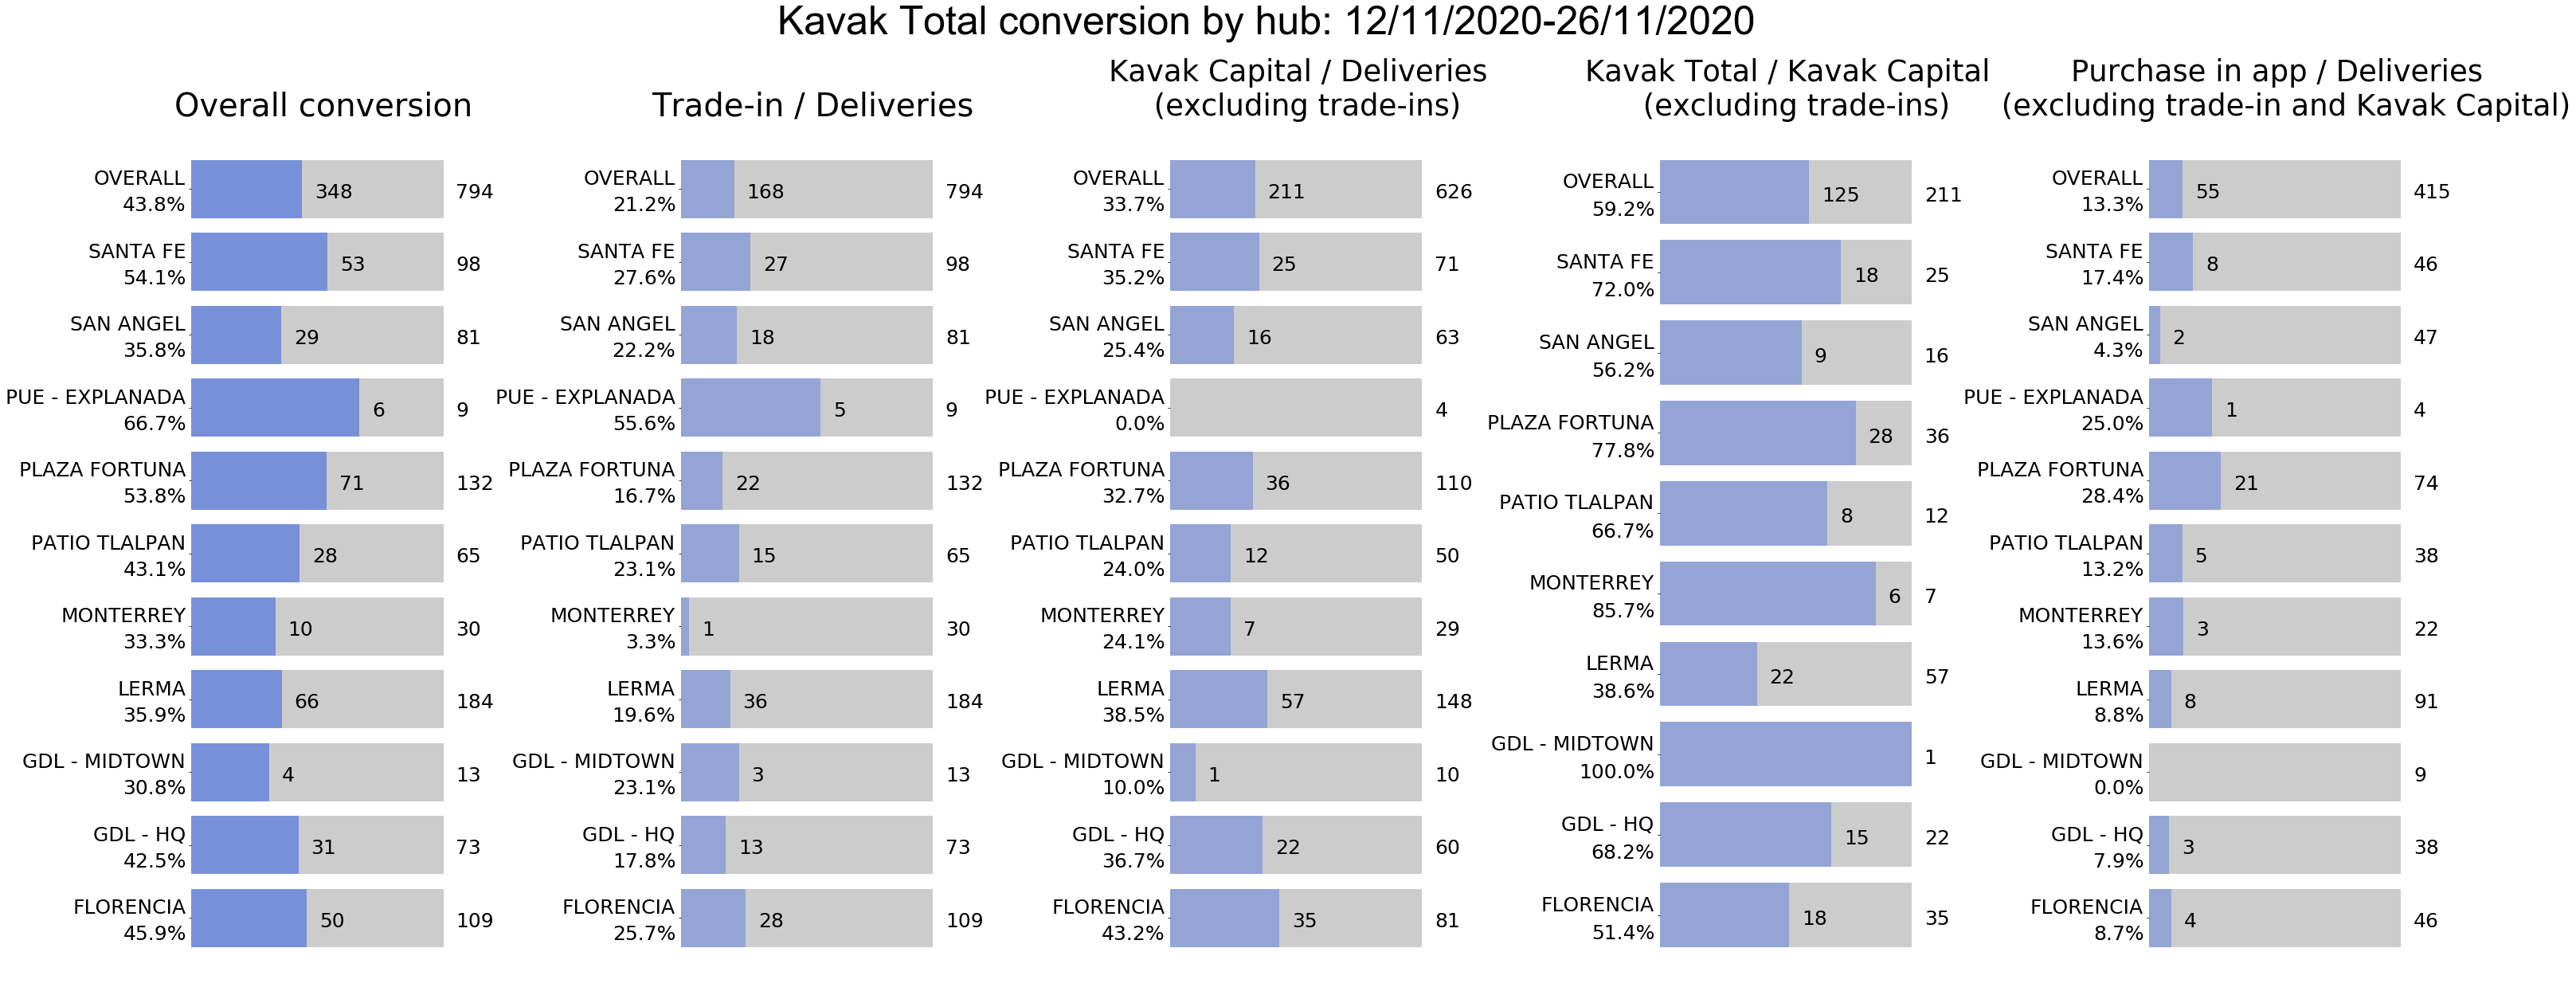

In [15]:
# GRAPH 1: 15 DAYS
# plot figure with 5 cols
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, sharex=True)
fig.set_figheight(20)
fig.set_figwidth(50)
### 1
bar1g = ax1.barh(x_ktot, [1] * len(x_ktot), alpha=.4, color="gray")
bar1 = ax1.barh(x_ktot, y_ktot_pr, alpha=.6, color="royalblue")
ax1.set_title('Overall conversion', fontsize=40)
ax1.set_yticklabels(x_ktot, va='bottom', fontsize=25)
### 2
bar2g = ax2.barh(x_ti, [1] * len(x_ti), alpha=.4, color="gray")
bar2 = ax2.barh(x_ti, y_ti_pr, alpha=.4, color="royalblue")
ax2.set_title('Trade-in / Deliveries', fontsize=40)
ax2.set_yticklabels(x_ti, va='bottom', fontsize=25)
### 3
bar3g = ax3.barh(x_kcap_noti, [1] * len(x_kcap_noti), alpha=.4, color="gray")
bar3 = ax3.barh(x_kcap_noti, y_kcap_noti_pr, alpha=.4, color="royalblue")
ax3.set_title('Kavak Capital / Deliveries \n (excluding trade-ins)', fontsize=37)
ax3.set_yticklabels(x_kcap_noti, va='bottom', fontsize=25)
### 4
bar4g = ax4.barh(x_ktot_kcap, [1] * len(x_ktot_kcap), alpha=.4, color="gray")
bar4 = ax4.barh(x_ktot_kcap, y_ktot_kcap_pr, alpha=.4, color="royalblue")
ax4.set_title('Kavak Total / Kavak Capital \n (excluding trade-ins)', fontsize=37)
ax4.set_yticklabels(x_ktot_kcap, va='bottom', fontsize=25)
### 5
bar5g = ax5.barh(x_ktot_ntikc, [1] * len(x_ktot_ntikc), alpha=.4, color="gray")
bar5 = ax5.barh(x_ktot_ntikc, y_ktot_ntikc_pr, alpha=.4, color="royalblue")
ax5.set_title('Purchase in app / Deliveries \n (excluding trade-in and Kavak Capital)', fontsize=37)
ax5.set_yticklabels(x_ktot_ntikc, va='bottom', fontsize=25)
# format axes, title, and labels
### axes
for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
plt.rc('ytick', labelsize=30) 
plt.subplots_adjust(wspace = 0.85)
### title
titlestr = ('Kavak Total conversion by hub: ' + hace_quince.strftime('%d/%m/%Y') + '-' + 
           ayer.strftime('%d/%m/%Y'))
fig.suptitle(titlestr, fontsize=50, fontname="Arial");
### labels
##### 1
for idx,rect in enumerate(bar1):
    if (y_ktot[idx] != 0):
        ax1.text(y_ktot_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr[idx]-y_ktot[idx]) != 0):
        ax1.text(1+.05, rect.get_y()+.35,
            int(y_entr[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax1.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
##### 2
for idx,rect in enumerate(bar2):
    if (y_ti[idx] != 0):
        ax2.text(y_ti_pr[idx]+.05, rect.get_y()+.35,
            int(y_ti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr[idx]-y_ti[idx]) != 0):
        ax2.text(1+.05, rect.get_y()+.35,
            int(y_entr[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax2.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ti_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0) 
##### 3
for idx,rect in enumerate(bar3):
    if (y_kcap_noti[idx] != 0):
        ax3.text(y_kcap_noti_pr[idx]+.05, rect.get_y()+.35,
            int(y_kcap_noti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr_noti[idx]-y_kcap_noti[idx]) != 0):
        ax3.text(1+.05, rect.get_y()+.35,
            int(y_entr_noti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax3.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_kcap_noti_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
##### 4
for idx,rect in enumerate(bar4):
    if (y_ktot_kcap[idx] != 0):
        ax4.text(y_ktot_kcap_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot_kcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr_kcap[idx]-y_ktot_kcap[idx]) != 0):
        ax4.text(1+.05, rect.get_y()+.35,
            int(y_entr_kcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax4.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_kcap_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
##### 5
for idx,rect in enumerate(bar5):
    if (y_ktot_ntikc[idx] != 0):
        ax5.text(y_ktot_ntikc_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot_ntikc[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_enoti_nkcap[idx]-y_ktot_ntikc[idx]) != 0):
        ax5.text(1+.05, rect.get_y()+.35,
            int(y_enoti_nkcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax5.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_ntikc_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
# save fig
#plt.savefig('hub_performance_15d.png') 

In [16]:
# GRAPH 2: MTD
# calculations
# cols 1-2
### add month and year cols
df_entregas['month'] = df_entregas['date_delivery'].dt.month
df_entregas['year'] = df_entregas['date_delivery'].dt.year
### find curr month and year 
curr_month = pd.to_datetime(datetime.date(datetime.now())).month
curr_year = pd.to_datetime(datetime.date(datetime.now())).year
### include only curr month
df_curm = df_entregas[(df_entregas['month'] == curr_month) & (df_entregas['year'] == curr_year)]
### initialize dics
month_entregas = OrderedDict() 
month_ktotal = OrderedDict() 
month_ti = OrderedDict()
### find num of entregas, ktotal, and tradeins
for hub, frame in df_curm.groupby(['hub']):
    if (hub == 'Sin asignar'): 
        print(frame)
    month_entregas[hub] = len(frame)
    month_ktotal[hub] = sum(frame['ktotal']==1)
    month_ti[hub] = sum(frame['tradein']==1)
### find overalls
month_entregas['OVERALL'] = len(df_curm)
month_ktotal['OVERALL'] = sum(df_curm['ktotal']==1)
month_ti["OVERALL"] = sum(df_curm['tradein']==1)
### set x and y values: entregas 
if ('Sin asignar' in month_entregas.keys()):
    month_entregas.pop('Sin asignar')
x_entr = month_entregas.keys()
y_entr = [float(i) for i in month_entregas.values()] 
### 1: set x and y values: ktotal 
if ('Sin asignar' in month_ktotal.keys()):
    month_ktotal.pop('Sin asignar')
x_ktot = month_ktotal.keys()
y_ktot = [float(i) for i in month_ktotal.values()] 
y_ktot_pr = [i / j for i, j in zip(y_ktot, y_entr)]
### 2: set x and y values: tradeins
if ('Sin asignar' in month_ti.keys()):
    month_ti.pop('Sin asignar')
x_ti = month_ti.keys()
y_ti = [float(i) for i in month_ti.values()] 
y_ti_pr = [i / j for i, j in zip(y_ti, y_entr)]

In [17]:
# GRAPH 2: MTD
# col 3
### exclude trade-ins
df_curr_month_noti = df_curm[df_curm['tradein']==0]
### initialize dics
month_entregas_noti = OrderedDict()
month_kcap_noti = OrderedDict()
### find num of entregas, kcapital
for hub, frame in df_curr_month_noti.groupby(['hub']):
    month_entregas_noti[hub] = len(frame)
    month_kcap_noti[hub] = sum(frame['kcapital']==1)
### find overalls
month_entregas_noti['OVERALL'] = len(df_curr_month_noti)
month_kcap_noti['OVERALL'] = sum(df_curr_month_noti['kcapital']==1)
### set x and y values: entregas 
if ('Sin asignar' in month_entregas_noti.keys()):
    month_entregas_noti.pop('Sin asignar')
x_entr_noti = month_entregas_noti.keys()
y_entr_noti = [float(i) for i in month_entregas_noti.values()] 
### 3: set x and y values: kcapital 
if ('Sin asignar' in month_kcap_noti.keys()):
    month_kcap_noti.pop('Sin asignar')
x_kcap_noti = month_kcap_noti.keys()
y_kcap_noti = [float(i) for i in month_kcap_noti.values()] 
y_kcap_noti_pr = [i / j for i, j in zip(y_kcap_noti, y_entr_noti)]

In [42]:
# GRAPH 2: MTD
# col 4
### consider only kcapital (excluding trade-ins)
df_curr_month_kcap = df_curm[(df_curm['kcapital']==1) & (df_curm['tradein']==0)]
### initialize dics
month_entregas_kcap = OrderedDict()
month_ktot_kcap = OrderedDict()
### find num of entregas, kcapital
for hub, frame in df_curr_month_kcap.groupby(['hub']):
    month_entregas_kcap[hub] = len(frame)
    month_ktot_kcap[hub] = sum(frame['ktotal']==1)
### find overalls
month_entregas_kcap['OVERALL'] = len(df_curr_month_kcap)
month_ktot_kcap['OVERALL'] = sum(df_curr_month_kcap['ktotal']==1)
### set x and y values: entregas 
if ('Sin asignar' in month_entregas_kcap.keys()):
    month_entregas_kcap.pop('Sin asignar')
x_entr_kcap = month_entregas_kcap.keys()
y_entr_kcap = [float(i) for i in month_entregas_kcap.values()] 
### set x and y values: kcapital 
if ('Sin asignar' in month_ktot_kcap.keys()):
    month_ktot_kcap.pop('Sin asignar')
x_ktot_kcap = month_ktot_kcap.keys()
y_ktot_kcap = [float(i) for i in month_ktot_kcap.values()] 
y_ktot_kcap_pr = [i / j for i, j in zip(y_ktot_kcap, y_entr_kcap)]

In [54]:
# GRAPH 2: MTD
# col 5
### exclude trade-ins and kcapital
dfm_noti_nkcap = df_curm[(df_curm['tradein']==0) & (df_curm['kcapital']==0)]
### initialize dics
notim_nkcap = OrderedDict()
ktotm_noti_nkcap = OrderedDict()
### find num of entregas, ktotal
for hub, frame in dfm_noti_nkcap.groupby(['hub']):
    notim_nkcap[hub] = len(frame)
    ktotm_noti_nkcap[hub] = sum(frame['ktotal']==1)
### find overalls
notim_nkcap['OVERALL'] = len(dfm_noti_nkcap)
ktotm_noti_nkcap['OVERALL'] = sum(dfm_noti_nkcap['ktotal']==1)
### add non converted financed cars
for i in range(len(notim_nkcap)):
    if (notim_nkcap.keys()[i] in month_entregas_kcap.keys()):
        hub = notim_nkcap.keys()[i]
        notim_nkcap[hub] = notim_nkcap[hub] + abs(month_entregas_kcap[hub] - month_ktot_kcap[hub])
### set x and y values: entregas 
if ('Sin asignar' in notim_nkcap.keys()):
    notim_nkcap.pop('Sin asignar')
x_enoti_nkcap = notim_nkcap.keys()
y_enoti_nkcap = [float(i) for i in notim_nkcap.values()] 
### set x and y values: ktotal 
if ('Sin asignar' in ktotm_noti_nkcap.keys()):
    ktotm_noti_nkcap.pop('Sin asignar')
x_ktot_ntikc = ktotm_noti_nkcap.keys()
y_ktot_ntikc = [float(i) for i in ktotm_noti_nkcap.values()] 
y_ktot_ntikc_pr = [i / j for i, j in zip(y_ktot_ntikc, y_enoti_nkcap)]

In [ ]:
# GRAPH 2: MTD
# plot figure with 5 cols
fig2, (ax21, ax22, ax23, ax24, ax25) = plt.subplots(1,5, sharex=True)
fig2.set_figheight(20)
fig2.set_figwidth(50)
### 1
bar21g = ax21.barh(x_ktot, [1] * len(x_ktot), alpha=.4, color="gray")
bar21 = ax21.barh(x_ktot, y_ktot_pr, alpha=.6, color="royalblue")
ax21.set_title('Overall conversion', fontsize=40, va='top')
ax21.set_yticklabels(x_ktot, va='bottom', fontsize=25)
### 2
bar22g = ax22.barh(x_ti, [1] * len(x_ti), alpha=.4, color="gray")
bar22 = ax22.barh(x_ti, y_ti_pr, alpha=.4, color="royalblue")
ax22.set_title('Trade-in / Deliveries', fontsize=40, va='top')
ax22.set_yticklabels(x_ti, va='bottom', fontsize=25)
### 3
bar23g = ax23.barh(x_kcap_noti, [1] * len(x_kcap_noti), alpha=.4, color="gray")
bar23 = ax23.barh(x_kcap_noti, y_kcap_noti_pr, alpha=.4, color="royalblue")
ax23.set_title('Kavak Capital / Deliveries \n (available universe)', fontsize=37, va='center')
ax23.set_yticklabels(x_kcap_noti, va='bottom', fontsize=25)
### 4
bar24g = ax24.barh(x_ktot_kcap, [1] * len(x_ktot_kcap), alpha=.4, color="gray")
bar24 = ax24.barh(x_ktot_kcap, y_ktot_kcap_pr, alpha=.4, color="royalblue")
ax24.set_title('Kavak Total / Kavak Capital \n (available universe)', fontsize=37, va='center')
ax24.set_yticklabels(x_ktot_kcap, va='bottom', fontsize=25)
### 5
bar25g = ax25.barh(x_ktot_ntikc, [1] * len(x_ktot_ntikc), alpha=.4, color="gray")
bar25 = ax25.barh(x_ktot_ntikc, y_ktot_ntikc_pr, alpha=.4, color="royalblue")
ax25.set_title('Purchase in app / Deliveries \n (available universe)', fontsize=37, va='center')
ax25.set_yticklabels(x_ktot_ntikc, va='bottom', fontsize=25)
# format axes, title, and labels
### axes
for ax in (ax21, ax22, ax23, ax24, ax25):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
plt.rc('ytick', labelsize=30) 
plt.subplots_adjust(wspace = 0.85)
### title
titlestr = ('Kavak Total Conversion by Hub: MTD')
fig2.suptitle(titlestr, fontsize=50, fontname="Arial", va='top');
### labels
##### 1
for idx,rect in enumerate(bar21):
    if (y_ktot[idx] != 0):
        ax21.text(y_ktot_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr[idx]-y_ktot[idx]) != 0):
        ax21.text(1+.05, rect.get_y()+.35,
            int(y_entr[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax21.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
##### 2
for idx,rect in enumerate(bar22):
    if (y_ti[idx] != 0):
        ax22.text(y_ti_pr[idx]+.05, rect.get_y()+.35,
            int(y_ti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr[idx]-y_ti[idx]) != 0):
        ax22.text(1+.05, rect.get_y()+.35,
            int(y_entr[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax22.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ti_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0) 
##### 3
for idx,rect in enumerate(bar23):
    if (y_kcap_noti[idx] != 0):
        ax23.text(y_kcap_noti_pr[idx]+.05, rect.get_y()+.35,
            int(y_kcap_noti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr_noti[idx]-y_kcap_noti[idx]) != 0):
        ax23.text(1+.05, rect.get_y()+.35,
            int(y_entr_noti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax23.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_kcap_noti_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
##### 4
for idx,rect in enumerate(bar24):
    if (y_ktot_kcap[idx] != 0):
        ax24.text(y_ktot_kcap_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot_kcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr_kcap[idx]-y_ktot_kcap[idx]) != 0):
        ax24.text(1+.05, rect.get_y()+.35,
            int(y_entr_kcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax24.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_kcap_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
##### 5
for idx,rect in enumerate(bar25):
    if (y_ktot_ntikc[idx] != 0):
        ax25.text(y_ktot_ntikc_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot_ntikc[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_enoti_nkcap[idx]-y_ktot_ntikc[idx]) != 0):
        ax25.text(1+.05, rect.get_y()+.35,
            int(y_enoti_nkcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax25.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_ntikc_pr[idx]), fontsize=25,
            ha='right', va='center', rotation=0)
### add timestamp
hoy = datetime.date(datetime.now())
ax21.text(-1, 12, hoy.strftime('%d/%m/%Y'), fontsize=30)
# save fig
plt.savefig('hub_performance_mtd.png') 

In [ ]:
# GRAPH 3: MTD (kcap + earth sales only)
### exclude tradeins
df_noti = df_entregas[df_entregas['tradein']==0]
### initialize dic
perf_hubs = OrderedDict()
### find number of deliveries, ktotal
for hub, frame in df_noti.groupby(['hub']):
    entr = float(len(frame))
    ktot = float(sum(frame['ktotal']==1))
    perf_hubs[hub] = float(entr/ktot)
    
    


### set x and y values: entregas 
if ('Sin asignar' in notim_nkcap.keys()):
    notim_nkcap.pop('Sin asignar')
x_enoti_nkcap = notim_nkcap.keys()
y_enoti_nkcap = [float(i) for i in notim_nkcap.values()] 
### set x and y values: ktotal 
if ('Sin asignar' in ktotm_noti_nkcap.keys()):
    ktotm_noti_nkcap.pop('Sin asignar')
x_ktot_ntikc = ktotm_noti_nkcap.keys()
y_ktot_ntikc = [float(i) for i in ktotm_noti_nkcap.values()] 
y_ktot_ntikc_pr = [i / j for i, j in zip(y_ktot_ntikc, y_enoti_nkcap)]    
    

### add timestamp
hoy = datetime.date(datetime.now())
ax21.text(-1, 12, hoy.strftime('%d/%m/%Y'), fontsize=30)  
### save plot

In [90]:
# deliveries per hour
### find curr day, month, and year
curr_day = datetime.date(datetime.now()).day
curr_month = datetime.date(datetime.now()).month
curr_year = datetime.date(datetime.now()).year
print("Promedio de entregas por hora MTD (" + str(curr_day) + "-" + str(curr_month) + "-" + str(curr_year) + ")")
print("\n")
### filter data by curr month + year
df_month = df_entregas[(df_entregas['date_delivery'].dt.month == curr_month) &
                      (df_entregas['date_delivery'].dt.year == curr_year) &
                      (df_entregas['date_delivery'].dt.day <= curr_day)]
### create day col
df_month['day'] = df_month['date_delivery'].dt.day
### find hourly delivery averages for each hub
for hub, frame in df_month.groupby(['hub']):
    if(hub=='Sin asignar'): continue
    print(hub)
    for hour, frame_hour in frame.groupby(['hour']):
        sumh = float(len(frame_hour))
        days = float(len(set(frame_hour['day'])))
        avg = round(float(sumh/days), 2)
        if(avg != 1): print(hour + ": " + str(avg)) 
        else: continue
    print("\n")

Promedio de entregas por hora MTD (27-11-2020)


FLORENCIA
10:00: 1.44
10:30: 1.5
11:00: 1.2
12:00: 1.6
13:00: 1.38
13:30: 1.25
14:00: 1.57
15:00: 1.25
16:00: 1.25
16:15: 1.2
17:00: 1.33
17:30: 1.17


/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


19:45: 1.5


GDL - HQ
10:00: 1.5
11:00: 1.08
12:00: 1.11
13:00: 1.1
16:00: 1.14
17:00: 1.6
17:30: 1.5
9:30: 1.5


GDL - MIDTOWN
16:00: 1.5


LERMA
10:00: 1.17
11:00: 1.43
12:00: 1.88
13:00: 1.62
14:00: 1.15
15:00: 1.93
15:30: 1.25
16:00: 2.0
17:00: 1.64
17:30: 1.14
18:00: 1.25
19:00: 1.5
19:45: 2.0
20:00: 1.17
22:00: 1.25


MONTERREY
10:00: 1.14
12:00: 1.5
17:00: 1.25


PATIO TLALPAN
12:00: 1.25
16:00: 1.2
9:00: 2.0


PLAZA FORTUNA
10:00: 1.44
11:00: 1.57
12:00: 1.65
13:00: 1.08
14:00: 1.2
15:00: 1.2
16:00: 1.18
17:00: 1.27
17:15: 2.0
18:00: 1.2
18:30: 1.33
20:00: 1.2


PUE - EXPLANADA


SAN ANGEL
12:00: 1.13
12:30: 2.0
13:00: 1.33
14:00: 1.33
15:00: 1.33
16:00: 1.23
16:30: 1.5


SANTA FE
10:00: 1.2
11:00: 1.3
11:30: 2.0
12:00: 1.07
14:00: 1.25
16:00: 1.13
17:00: 1.63


